# Fit global epistasis models to DMS data

The [`dms_variants.globalepistasis`](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis) module is based off the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) -- that there exists an underlying latent phenotype that mutations affect additively, and
then an observed (measured) phenotype that is a non-linear
function of the latent phenotype.


## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import os
import itertools
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

import yaml

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.4.7


Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [6]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [7]:
os.makedirs(config['global_epistasis_binding_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

## Read in Tite-seq affinity scores by barcode
Read in ddG measurements. Rename ddG column to be func_score, and calculate variance from the ddG_SE column. Remove rows with NaN for func_score. For empty aa_substitutions (wildtype), it is being replaced with NA. Make back to an empty string.

In [8]:
df = pd.read_csv(config['Titeseq_Kds_file'])
df.rename(columns={'ddG':'func_score'},inplace=True)
df['func_score_var'] = df['ddG_SE']**2
func_scores = df[pd.notnull(df['func_score'])]
func_scores.fillna('',inplace=True)
func_scores.head()

,Unnamed: 0,library,sample,barcode,variant_call_support,average_counts,dG,dG_SE,func_score,ddG_SE,Kd,response,baseline,RSE,max_cens,max_SE,variant_class,aa_substitutions,n_aa_substitutions,func_score_var
0,1,libA2,191010,AAAAAAAAAAAACCAG,3,22.044070,-5.608016,1.400000,8.095255,1.400001,7.270000e-05,2.000000,1.150418,0.626555,1,1,>1 nonsynonymous,L86W G233E,2,1.960004
1,2,libA2,191010,AAAAAAAAAAAAGGTA,1,15.294056,-12.421733,0.225910,1.281537,0.225919,6.812630e-10,2.000000,1.074706,0.530851,0,0,>1 nonsynonymous,L20T P182A,2,0.051039
2,3,libA2,191010,AAAAAAAAAAACTCAA,3,35.920991,-5.608016,1.400000,8.095255,1.400001,7.270000e-05,2.000000,1.179027,0.977322,1,1,>1 nonsynonymous,N31S T71C G195K R199G D220G Q239C,6,1.960004
3,4,libA2,191010,AAAAAAAAAAGCACTA,2,9.535048,-5.608016,1.400000,8.095255,1.400001,7.270000e-05,2.000000,1.232260,1.273703,1,1,>1 nonsynonymous,D111I W173R,2,1.960004
4,5,libA2,191010,AAAAAAAAAATAGTTA,1,26.524565,-12.932871,0.372101,0.770400,0.372106,2.858368e-10,2.379747,1.244800,1.105624,0,0,1 nonsynonymous,L20T,1,0.138463


## Fit global epistasis models
We now fit global epistasis models to the functional scores.
For background on these models, see [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
The models we fits are implemented in [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html), which has extensive documentation.

The primary model of interest is [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis), which assumes that the observed phenotype is a monotonic non-linear function of an underlying additive latent phenotype.
As a control, we also fit a [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, which assumes that mutations simply contribute additively to the observed phenotype:

For the fitting, we first convert the set of functional scores into a binary representation using a [BinaryMap]((https://jbloomlab.github.io/dms_variants/dms_variants.binarymap.html#dms_variants.binarymap.BinaryMap)).
Then we create the model, fit it, and store it.

In [9]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(epistasistype, likelihoodtype, sample, lib)`

for (sample, lib), scores in func_scores.groupby(['sample',
                                                  'library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {sample}, {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasistype, likelihoodtype, sample, lib)] = model

Fitting global epistasis with Gaussian likelihood model to 191010, libA2... fitting took 67.6 sec.
Fitting no epistasis with Gaussian likelihood model to 191010, libA2... fitting took 4.7 sec.
Fitting global epistasis with Cauchy likelihood model to 191010, libA2... fitting took 189.6 sec.
Fitting no epistasis with Cauchy likelihood model to 191010, libA2... fitting took 20.6 sec.
Fitting global epistasis with Gaussian likelihood model to 200102, libB2... fitting took 61.7 sec.
Fitting no epistasis with Gaussian likelihood model to 200102, libB2... fitting took 2.8 sec.
Fitting global epistasis with Cauchy likelihood model to 200102, libB2... fitting took 137.9 sec.
Fitting no epistasis with Cauchy likelihood model to 200102, libB2... fitting took 17.8 sec.


Now we want to see which model fits the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better, and below we see that the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model always fits the data much better. (Note, I previous tried alterning number of meshpoints, and the default 4 was the lowest AIC):

In [10]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, likelihoodtype, sample, lib, model.nparams, model.loglik) for
             (epistasistype, likelihoodtype, sample, lib), model in models.items()],
            columns=['model', 'likelihood type', 'sample', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['sample', 'library'])
    )

logliks_df.round(1)

model likelihood type  n_parameters  log_likelihood       AIC
sample library                                                                          
191010 libA2    global epistasis        Gaussian          4426        -87765.6  184383.1
       libA2        no epistasis        Gaussian          4420       -118222.9  245285.8
       libA2    global epistasis          Cauchy          4426        -78033.4  164918.9
       libA2        no epistasis          Cauchy          4420        -91113.6  191067.1
200102 libB2    global epistasis        Gaussian          4424        -74371.0  157590.1
       libB2        no epistasis        Gaussian          4418       -103094.6  215025.3
       libB2    global epistasis          Cauchy          4424        -72273.6  153395.1
       libB2        no epistasis          Cauchy          4418        -85776.5  180388.9

In [11]:
# check to confirm the global epistasis model is better in all cases
assert (logliks_df
        .reset_index()
        .pivot_table(index=['sample', 'library'],
                     values='AIC',
                     columns='model'
                     )
        .assign(global_better=lambda x: x['global epistasis'] < x['no epistasis'])
        ['global_better']
        .all()
        )

Because the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis models fit so much better than the additive [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) models, below we are just going to analyze the results from the global epistasis model.

First, we will examine how the model looks on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.

In [12]:
# NBVAL_IGNORE_OUTPUT

variants_df = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 library=lib,
                 likelihoodtype=likelihoodtype,
                 )
         for (epistasistype, likelihoodtype, sample, lib), model in models.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

predictionsfile = os.path.join(config['global_epistasis_binding_dir'], 'globalepistasis_binding_predictions.csv')
variants_df.to_csv(predictionsfile, index=False)
print(f"Writing predictions to {predictionsfile}")

variants_df.head().round(2)

Writing predictions to results/global_epistasis_binding/globalepistasis_binding_predictions.csv


,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,sample,library,likelihoodtype
0,L86W G233E,8.10,1.96,3.91,6.18,191010,libA2,Gaussian
1,L20T P182A,1.28,0.05,1.58,1.07,191010,libA2,Gaussian
2,N31S T71C G195K R199G D220G Q239C,8.10,1.96,6.74,6.81,191010,libA2,Gaussian
3,D111I W173R,8.10,1.96,5.42,6.81,191010,libA2,Gaussian
4,L20T,0.77,0.14,0.71,0.45,191010,libA2,Gaussian


Below we plot the relationships among the latent phenotype from the model, the observed phenotype from the model, and the measured functional score for all variants used to fit the model:

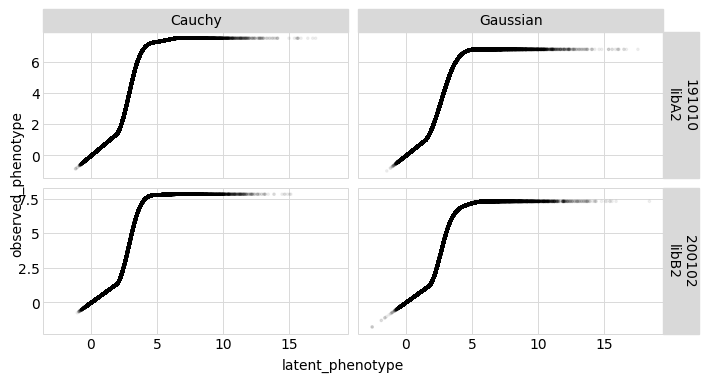

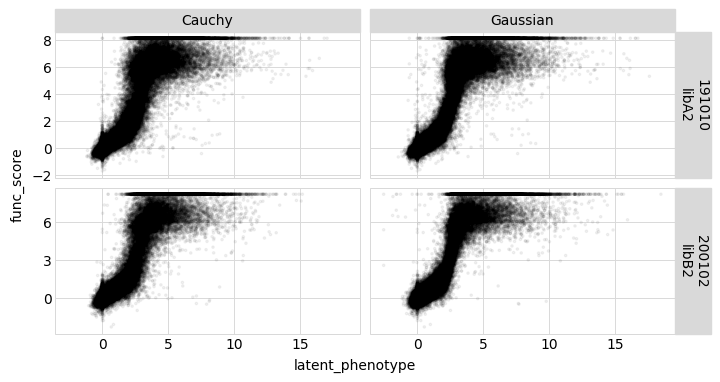

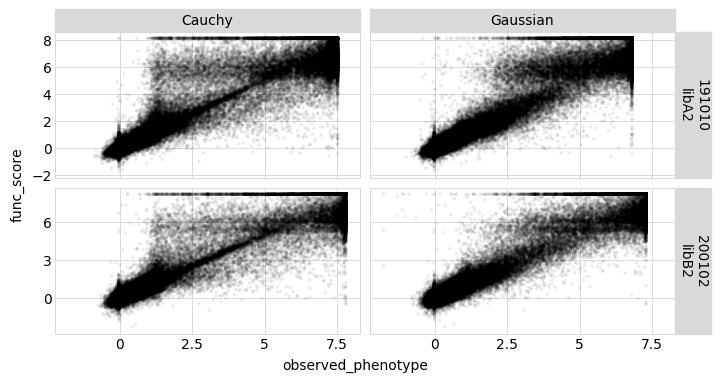

In [13]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library+sample ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * (variants_df['sample'].nunique()+variants_df['likelihoodtype'].nunique()),
                           2 * variants_df['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

Remember -- for ddG, in contrast to typical functional scores (e.g. enrichment-based), positive means *deleterious* mutation, zero is a neutral mutation, and a negative ddG means improved binding.

I want to look at these curves for single mutants only -- I hope to see less of the cloud of points that have high experimental phenotype (func_score) but lower predicted phenotype (observed_phenotype). This would indicate to me that these points exhibit negative epistasis amongst multiple mutants, which individually are predicted to be tolerated (hence the decent predicted phenotype from single mutant effects) but in combination have severely reduced affinity. (My assumption is that this is specific epistasis, but I can also imagine this could come from incomplete nonlinear correction -- if my latent scale doesn't make "bad" mutations "bad" enough, then a double mutant might be predicted to be decent when in reality it is really bad.) This latter explanation could also explain why Cauchy has less of these points than Gaussian, because Cauchy lets individual mutational effects on the latent scale be "worse" than Gaussian

In [14]:
#add predicted and latent phenotypes to table by barcode with additional columns used for interpretation
dt = pd.read_csv(config['Titeseq_Kds_file'])
dt[['aa_substitutions']] = dt[['aa_substitutions']].fillna(value='')
#dt_a = dt[dt.library=='libA2']
#dt_b = dt[dt.library=='libB2']


dt = models.get(('global epistasis', 'Gaussian', 191010, 'libA2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_A',observed_phenotype_col='predicted_phenotype_Gaussian_A',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 191010, 'libA2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_A',observed_phenotype_col='predicted_phenotype_Cauchy_A',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Gaussian', 200102, 'libB2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_B',observed_phenotype_col='predicted_phenotype_Gaussian_B',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 200102, 'libB2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_B',observed_phenotype_col='predicted_phenotype_Cauchy_B',unknown_as_nan=True)

predictionsfile = os.path.join(config['global_epistasis_binding_dir'], 'globalepistasis_binding_predictions_wide.csv')
dt.to_csv(predictionsfile, index=False)
print(f"Writing predictions to {predictionsfile}")

dt.head().round(2)

Writing predictions to results/global_epistasis_binding/globalepistasis_binding_predictions_wide.csv


,Unnamed: 0,library,sample,barcode,variant_call_support,average_counts,dG,dG_SE,ddG,ddG_SE,Kd,response,baseline,RSE,max_cens,max_SE,variant_class,aa_substitutions,n_aa_substitutions,latent_phenotype_Gaussian_A,predicted_phenotype_Gaussian_A,latent_phenotype_Cauchy_A,predicted_phenotype_Cauchy_A,latent_phenotype_Gaussian_B,predicted_phenotype_Gaussian_B,latent_phenotype_Cauchy_B,predicted_phenotype_Cauchy_B
0,1,libA2,191010,AAAAAAAAAAAACCAG,3,22.04,-5.61,1.40,8.10,1.40,0.0,2.00,1.15,0.63,1,1,>1 nonsynonymous,L86W G233E,2,3.91,6.18,4.06,6.91,4.02,6.75,4.27,7.60
1,2,libA2,191010,AAAAAAAAAAAAGGTA,1,15.29,-12.42,0.23,1.28,0.23,0.0,2.00,1.07,0.53,0,0,>1 nonsynonymous,L20T P182A,2,1.58,1.07,1.35,0.93,1.80,1.22,1.71,1.14
2,3,libA2,191010,AAAAAAAAAAACTCAA,3,35.92,-5.61,1.40,8.10,1.40,0.0,2.00,1.18,0.98,1,1,>1 nonsynonymous,N31S T71C G195K R199G D220G Q239C,6,6.74,6.81,7.51,7.53,6.31,7.30,6.83,7.81
3,4,libA2,191010,AAAAAAAAAAGCACTA,2,9.54,-5.61,1.40,8.10,1.40,0.0,2.00,1.23,1.27,1,1,>1 nonsynonymous,D111I W173R,2,5.42,6.81,5.06,7.30,7.04,7.30,5.22,7.77
4,5,libA2,191010,AAAAAAAAAATAGTTA,1,26.52,-12.93,0.37,0.77,0.37,0.0,2.38,1.24,1.11,0,0,1 nonsynonymous,L20T,1,0.71,0.45,0.62,0.40,0.75,0.49,0.76,0.49


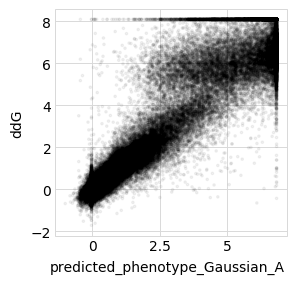

<ggplot: (8733036757098)>

In [15]:
#all genotypes
(ggplot(dt[dt.library=='libA2'], aes('predicted_phenotype_Gaussian_A', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

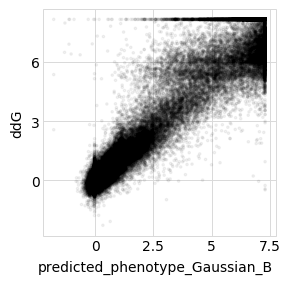

<ggplot: (-9223363303818018756)>

In [16]:
#all genotypes
(ggplot(dt[dt.library=='libB2'], aes('predicted_phenotype_Gaussian_B', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

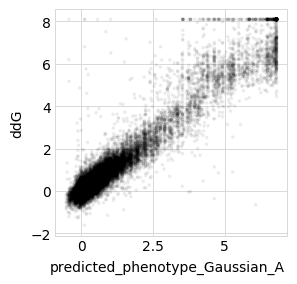

<ggplot: (8733028814319)>

In [17]:
#single mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Gaussian_A', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

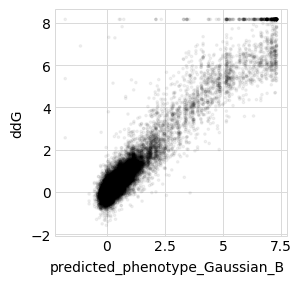

<ggplot: (8733019156670)>

In [18]:
#single mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Gaussian_B', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

Same with Cauchy likelihood

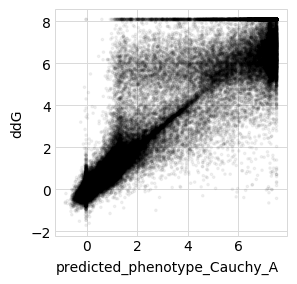

<ggplot: (8733020364671)>

In [19]:
#all genotypes
(ggplot(dt[dt.library=='libA2'], aes('predicted_phenotype_Cauchy_A', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

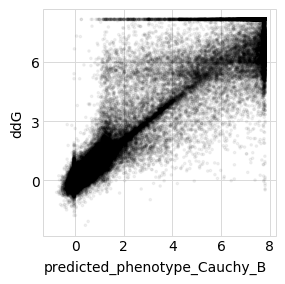

<ggplot: (8733020044215)>

In [20]:
#all genotypes
(ggplot(dt[dt.library=='libB2'], aes('predicted_phenotype_Cauchy_B', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

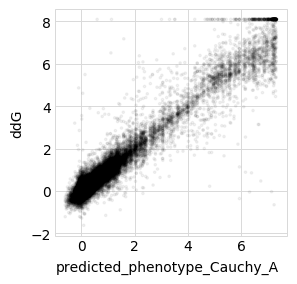

<ggplot: (8733037258195)>

In [21]:
#single mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Cauchy_A', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

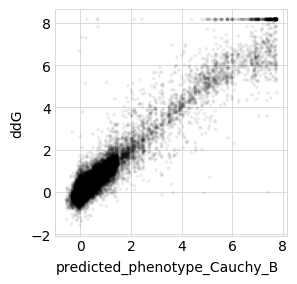

<ggplot: (8733020362097)>

In [22]:
#single mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Cauchy_B', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

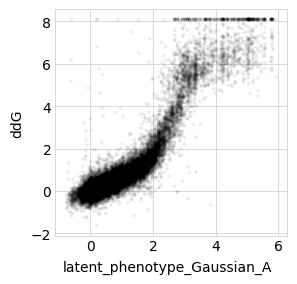

<ggplot: (-9223363303810960019)>

In [23]:
#look at ddG versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have epistasis)
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Gaussian_A', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

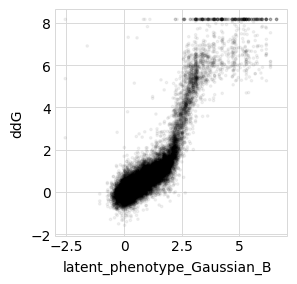

<ggplot: (8733037259405)>

In [24]:
#look at ddG versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have epistasis)
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Gaussian_B', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

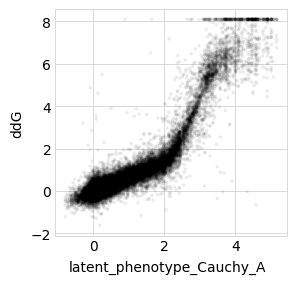

<ggplot: (-9223363303836351435)>

In [25]:
#look at ddG versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have epistasis)
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Cauchy_A', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

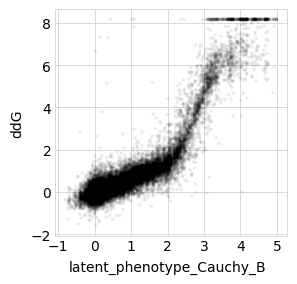

<ggplot: (-9223363303837783850)>

In [26]:
#look at ddG versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have epistasis)
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Cauchy_B', 'ddG')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

There is a bit more nonlinearity (by either likelihood method) than I expected within the ddGs that should be within my "detection limits". I wonder whether this indicates actual nonlinearity in my measured ddGs, or whether it's picking up something e.g. stability that causes nonlinearity in the ddG scale? Or artefactual consequence of the large number of genotypes at the censored upper maximum ddG, which could percolate down and affect the inferred nonlinearity even in the "linear" range. I am unsure then whether I want to use the beta coefficients on the latent scale or the "predicted"/"observed" scale as my proxies for ddG measurements. I will probably need to select genotypes and just validate them with isogenic titrations to gain more insight into what's going on and which scale best correlates with actual ddG.

## Repeat fits without the maximum censored values

In each replicate, a portion of the Kds are fixed to a minimum value -- these are the variants that were a non-binding flat line across the entire concentration range, and therefore got the maximum possible Kd. This is supposed to be a "minimum" Kd/ddG for the variant, which is my way of saying, this variant has a Kd somewhere greater than (~1e-4). However, the global epistasis model takes this as a point estimate. It does correctly interpret that this is a massively censored region whose latent phenotype truly extends to much worse values, but I wonder if these points are still messing with model fitting. I want to try removing these variants and fit the models.

In [27]:
func_scores_no_cens = df[pd.notnull(df['func_score'])]
func_scores_no_cens.fillna('',inplace=True)
func_scores_no_cens = func_scores_no_cens[func_scores_no_cens.max_cens==0]
func_scores_no_cens.head()

,Unnamed: 0,library,sample,barcode,variant_call_support,average_counts,dG,dG_SE,func_score,ddG_SE,Kd,response,baseline,RSE,max_cens,max_SE,variant_class,aa_substitutions,n_aa_substitutions,func_score_var
1,2,libA2,191010,AAAAAAAAAAAAGGTA,1,15.294056,-12.421733,0.225910,1.281537,0.225919,6.812630e-10,2.000000,1.074706,0.530851,0,0,>1 nonsynonymous,L20T P182A,2,0.051039
4,5,libA2,191010,AAAAAAAAAATAGTTA,1,26.524565,-12.932871,0.372101,0.770400,0.372106,2.858368e-10,2.379747,1.244800,1.105624,0,0,1 nonsynonymous,L20T,1,0.138463
5,6,libA2,191010,AAAAAAAAAATCCAAT,3,154.463299,-13.344970,0.070737,0.358300,0.070764,1.419080e-10,3.000000,1.000000,0.403091,0,0,1 nonsynonymous,V123F,1,0.005008
7,8,libA2,191010,AAAAAAAAACTCCCTA,2,53.229084,-13.363544,0.120129,0.339727,0.120145,1.374994e-10,2.942050,1.066352,0.476396,0,0,>1 nonsynonymous,R62Y A92G S218F,3,0.014435
8,9,libA2,191010,AAAAAAAAAGAAATAG,4,62.812110,-11.900036,0.403506,1.803235,0.403510,1.653120e-09,2.000000,1.000000,1.271393,0,0,1 nonsynonymous,I196P,1,0.162821


In [28]:
# NBVAL_IGNORE_OUTPUT

models_no_cens = {}  # store models_no_cens, keyed by `(epistasistype, likelihoodtype, sample, lib)`

for (sample, lib), scores in func_scores_no_cens.groupby(['sample',
                                                          'library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {sample}, {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models_no_cens[(epistasistype, likelihoodtype, sample, lib)] = model

Fitting global epistasis with Gaussian likelihood model to 191010, libA2... fitting took 119.0 sec.
Fitting no epistasis with Gaussian likelihood model to 191010, libA2... fitting took 4.4 sec.
Fitting global epistasis with Cauchy likelihood model to 191010, libA2... fitting took 242.2 sec.
Fitting no epistasis with Cauchy likelihood model to 191010, libA2... fitting took 20.6 sec.
Fitting global epistasis with Gaussian likelihood model to 200102, libB2... fitting took 45.9 sec.
Fitting no epistasis with Gaussian likelihood model to 200102, libB2... fitting took 3.2 sec.
Fitting global epistasis with Cauchy likelihood model to 200102, libB2... fitting took 169.2 sec.
Fitting no epistasis with Cauchy likelihood model to 200102, libB2... fitting took 12.5 sec.


In [29]:
# NBVAL_IGNORE_OUTPUT

variants_df_no_cens = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 library=lib,
                 likelihoodtype=likelihoodtype,
                 )
         for (epistasistype, likelihoodtype, sample, lib), model in models_no_cens.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

#predictionsfile = os.path.join(config['global_epistasis_binding_dir'], 'globalepistasis_binding_predictions.csv')
#variants_df.to_csv(predictionsfile, index=False)
#print(f"Writing predictions to {predictionsfile}")

variants_df_no_cens.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,sample,library,likelihoodtype
0,L20T P182A,1.28,0.05,1.39,1.02,191010,libA2,Gaussian
1,L20T,0.77,0.14,0.62,0.44,191010,libA2,Gaussian
2,V123F,0.36,0.01,0.79,0.56,191010,libA2,Gaussian
3,R62Y A92G S218F,0.34,0.01,0.37,0.25,191010,libA2,Gaussian
4,I196P,1.80,0.16,1.74,1.57,191010,libA2,Gaussian


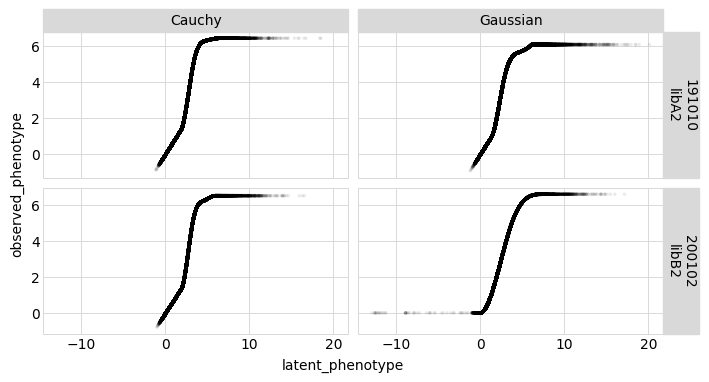

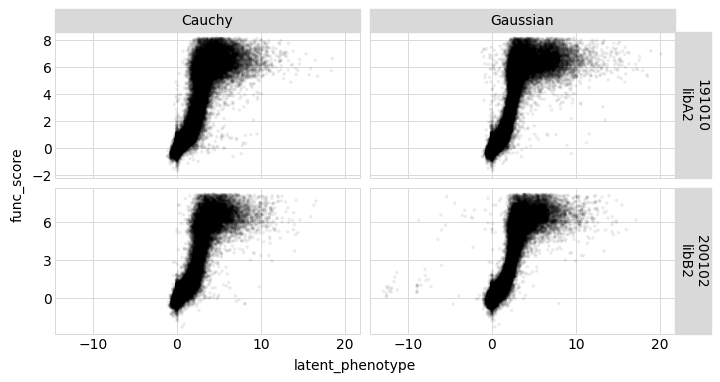

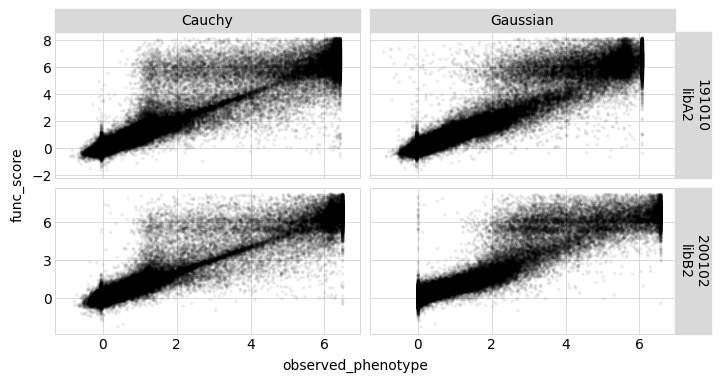

In [30]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df_no_cens, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library + sample ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * (variants_df_no_cens['sample'].nunique()+variants_df_no_cens['likelihoodtype'].nunique()),
                           2 * variants_df_no_cens['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

## Repeat fits without variants whose SE on the ddG was >1.4 kcal/mol

This is a bit more stringent than just those with the max Kd filtered above -- this also filters out many variants that are in the additional sort-of-censored region around ddG ~6, which also have a titration that is extrapolated out past the maximum concentration. (Excludes all the same variants as max_cens==1, and more)

In [31]:
func_scores_no_maxSE = df[pd.notnull(df['func_score'])]
func_scores_no_maxSE.fillna('',inplace=True)
func_scores_no_maxSE = func_scores_no_maxSE[func_scores_no_maxSE.max_SE==0]
func_scores_no_maxSE.head()

,Unnamed: 0,library,sample,barcode,variant_call_support,average_counts,dG,dG_SE,func_score,ddG_SE,Kd,response,baseline,RSE,max_cens,max_SE,variant_class,aa_substitutions,n_aa_substitutions,func_score_var
1,2,libA2,191010,AAAAAAAAAAAAGGTA,1,15.294056,-12.421733,0.225910,1.281537,0.225919,6.812630e-10,2.000000,1.074706,0.530851,0,0,>1 nonsynonymous,L20T P182A,2,0.051039
4,5,libA2,191010,AAAAAAAAAATAGTTA,1,26.524565,-12.932871,0.372101,0.770400,0.372106,2.858368e-10,2.379747,1.244800,1.105624,0,0,1 nonsynonymous,L20T,1,0.138463
5,6,libA2,191010,AAAAAAAAAATCCAAT,3,154.463299,-13.344970,0.070737,0.358300,0.070764,1.419080e-10,3.000000,1.000000,0.403091,0,0,1 nonsynonymous,V123F,1,0.005008
7,8,libA2,191010,AAAAAAAAACTCCCTA,2,53.229084,-13.363544,0.120129,0.339727,0.120145,1.374994e-10,2.942050,1.066352,0.476396,0,0,>1 nonsynonymous,R62Y A92G S218F,3,0.014435
8,9,libA2,191010,AAAAAAAAAGAAATAG,4,62.812110,-11.900036,0.403506,1.803235,0.403510,1.653120e-09,2.000000,1.000000,1.271393,0,0,1 nonsynonymous,I196P,1,0.162821


In [32]:
# NBVAL_IGNORE_OUTPUT

models_no_maxSE = {}  # store models, keyed by `(epistasistype, likelihoodtype, sample, lib)`

for (sample, lib), scores in func_scores_no_maxSE.groupby(['sample',
                                                        'library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores,func_score_var_col=None)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {sample}, {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models_no_maxSE[(epistasistype, likelihoodtype, sample, lib)] = model

Fitting global epistasis with Gaussian likelihood model to 191010, libA2... fitting took 56.9 sec.
Fitting no epistasis with Gaussian likelihood model to 191010, libA2... fitting took 0.3 sec.
Fitting global epistasis with Cauchy likelihood model to 191010, libA2... fitting took 158.3 sec.
Fitting no epistasis with Cauchy likelihood model to 191010, libA2... fitting took 13.0 sec.
Fitting global epistasis with Gaussian likelihood model to 200102, libB2... fitting took 34.8 sec.
Fitting no epistasis with Gaussian likelihood model to 200102, libB2... fitting took 0.2 sec.
Fitting global epistasis with Cauchy likelihood model to 200102, libB2... fitting took 205.3 sec.
Fitting no epistasis with Cauchy likelihood model to 200102, libB2... fitting took 10.3 sec.


In [33]:
# NBVAL_IGNORE_OUTPUT

variants_df_no_maxSE = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 library=lib,
                 likelihoodtype=likelihoodtype,
                 )
         for (epistasistype, likelihoodtype, sample, lib), model in models_no_maxSE.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

variants_df_no_maxSE.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,sample,library,likelihoodtype
0,L20T P182A,1.28,None,1.69,1.14,191010,libA2,Gaussian
1,L20T,0.77,None,0.69,0.45,191010,libA2,Gaussian
2,V123F,0.36,None,0.86,0.57,191010,libA2,Gaussian
3,R62Y A92G S218F,0.34,None,0.21,0.13,191010,libA2,Gaussian
4,I196P,1.80,None,2.24,1.75,191010,libA2,Gaussian


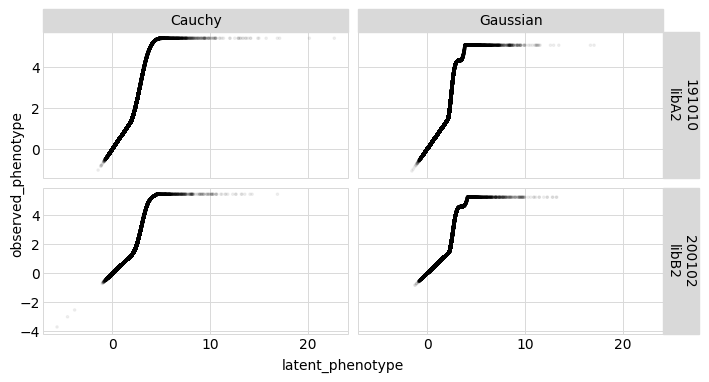

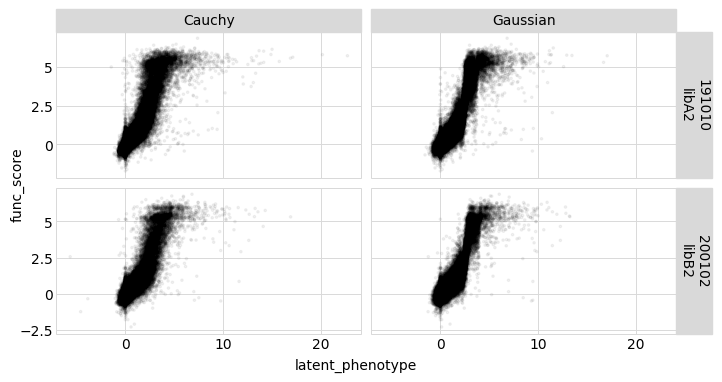

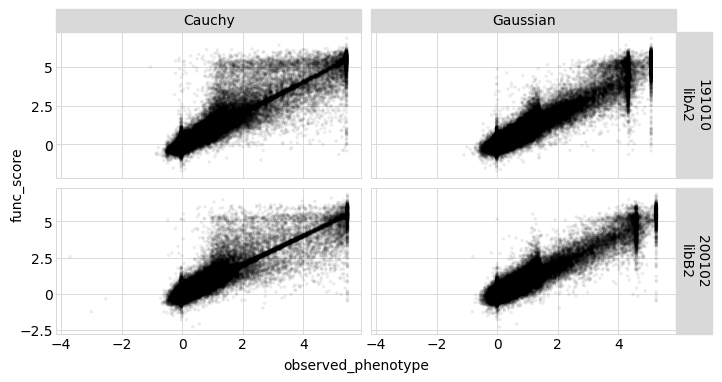

In [34]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df_no_maxSE, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library + sample ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * (variants_df_no_maxSE['sample'].nunique()+variants_df_no_maxSE['likelihoodtype'].nunique()),
                           2 * variants_df_no_maxSE['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

## Output epistasis model parameters

Load into R to look at correlations, etc., because I am terrible at Python

In [35]:
#models.get(('global epistasis', 'Gaussian', 191010, 'libA2')).preferences(phenotype='latent',missing='site_average').to_csv('results/global_epistasis_binding/Gaussian-preferences-binding.csv', index=False)
#models.get(('global epistasis', 'Cauchy', 191010, 'libA2')).preferences(phenotype='latent',missing='site_average').to_csv('results/global_epistasis_binding/Cauchy-preferences-binding.csv', index=False)


Get dataframe of the beta coefficients from the epistasis model. Rescale coefficients to be back on the ddG scale of the input?

In [36]:
models.get(('global epistasis', 'Gaussian', 191010, 'libA2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-latent-effects_binding_A.csv',index=False)
models.get(('global epistasis', 'Gaussian', 191010, 'libA2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-predicted-effects_binding_A.csv',index=False)
models.get(('global epistasis', 'Cauchy', 191010, 'libA2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-latent-effects_binding_A.csv',index=False)
models.get(('global epistasis', 'Cauchy', 191010, 'libA2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-predicted-effects_binding_A.csv',index=False)
models.get(('global epistasis', 'Gaussian', 200102, 'libB2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-latent-effects_binding_B.csv',index=False)
models.get(('global epistasis', 'Gaussian', 200102, 'libB2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Gaussian-predicted-effects_binding_B.csv',index=False)
models.get(('global epistasis', 'Cauchy', 200102, 'libB2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-latent-effects_binding_B.csv',index=False)
models.get(('global epistasis', 'Cauchy', 200102, 'libB2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/Cauchy-predicted-effects_binding_B.csv',index=False)
#and, output no epistasis models for Cauchy likelihood, to see how the global epistasis impacts correlation in mutational effects
models.get(('no epistasis', 'Cauchy', 191010, 'libA2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Cauchy-predicted-effects_binding_A.csv',index=False)
models.get(('no epistasis', 'Cauchy', 200102, 'libB2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_binding/nonepistatic-Cauchy-predicted-effects_binding_B.csv',index=False)

In [38]:
! jupyter nbconvert --to markdown global_epistasis_binding.ipynb --output-dir ./results/summary/ --output global_epistasis_binding.md

[NbConvertApp] Converting notebook global_epistasis_binding.ipynb to markdown
[NbConvertApp] Support files will be in global_epistasis_binding_files/
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_binding_files
[NbConvertApp] Making directory ./result